In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
%matplotlib inline

In [3]:
data=pd.read_csv('train.csv')
data.shape

(23116, 25)

In [4]:
data.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5498546,0.0,0,40364,0,0.0,3000,560,0.0,0.0,...,0.0,0,0.00,0,0,3,50000,46,NaN,0
1,5498604,1500.0,0,23456,0,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,3,35000,17,NaN,0
2,5498609,0.1,0,17999,3,0.0,9999,9999,0.1,9999.0,...,0.0,0,0.00,0,2,3,35000,58,NaN,0
3,5498645,5000.0,0,313247,0,0.0,0,9999,0.0,0.0,...,0.0,0,4923.97,0,0,5,35000,4,NaN,0
4,5498647,0.0,0,0,1,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,5,35000,34,NaN,0


In [5]:
#создадим списки вещественных и дискретных переменных
real_features=['cred_sum_cc_all',
               'cred_max_overdue_max_ly',
               'cred_sum_cc_ly',
               'cred_sum_debt_all_all',
               'mfo_cred_mean_sum_3lm',
               'cred_max_overdue_max_3lm',
               'cred_sum_overdue_cc_all']

discrete_features=['mfo_inqs_count_month',
                   'all_closed_creds_sum_all',
                   'bank_inqs_count_quarter',
                   'all_active_creds_sum_all',
                   'mfo_last_days_all',
                   'all_closed_creds_sum_ly',
                   'delay_more_sum_all',
                  'all_creds_count_all',
                   'cred_day_overdue_all_sum_all',
                   'mfo_closed_count_ly',
                   'count_overdue_all_3lm',
                   'all_creds_count_lm',
                   'month_income',
                   'region',
                   #'bad',
                   'approved']

cat_features=['work_code']

### Графики распределения Вещественных признаков

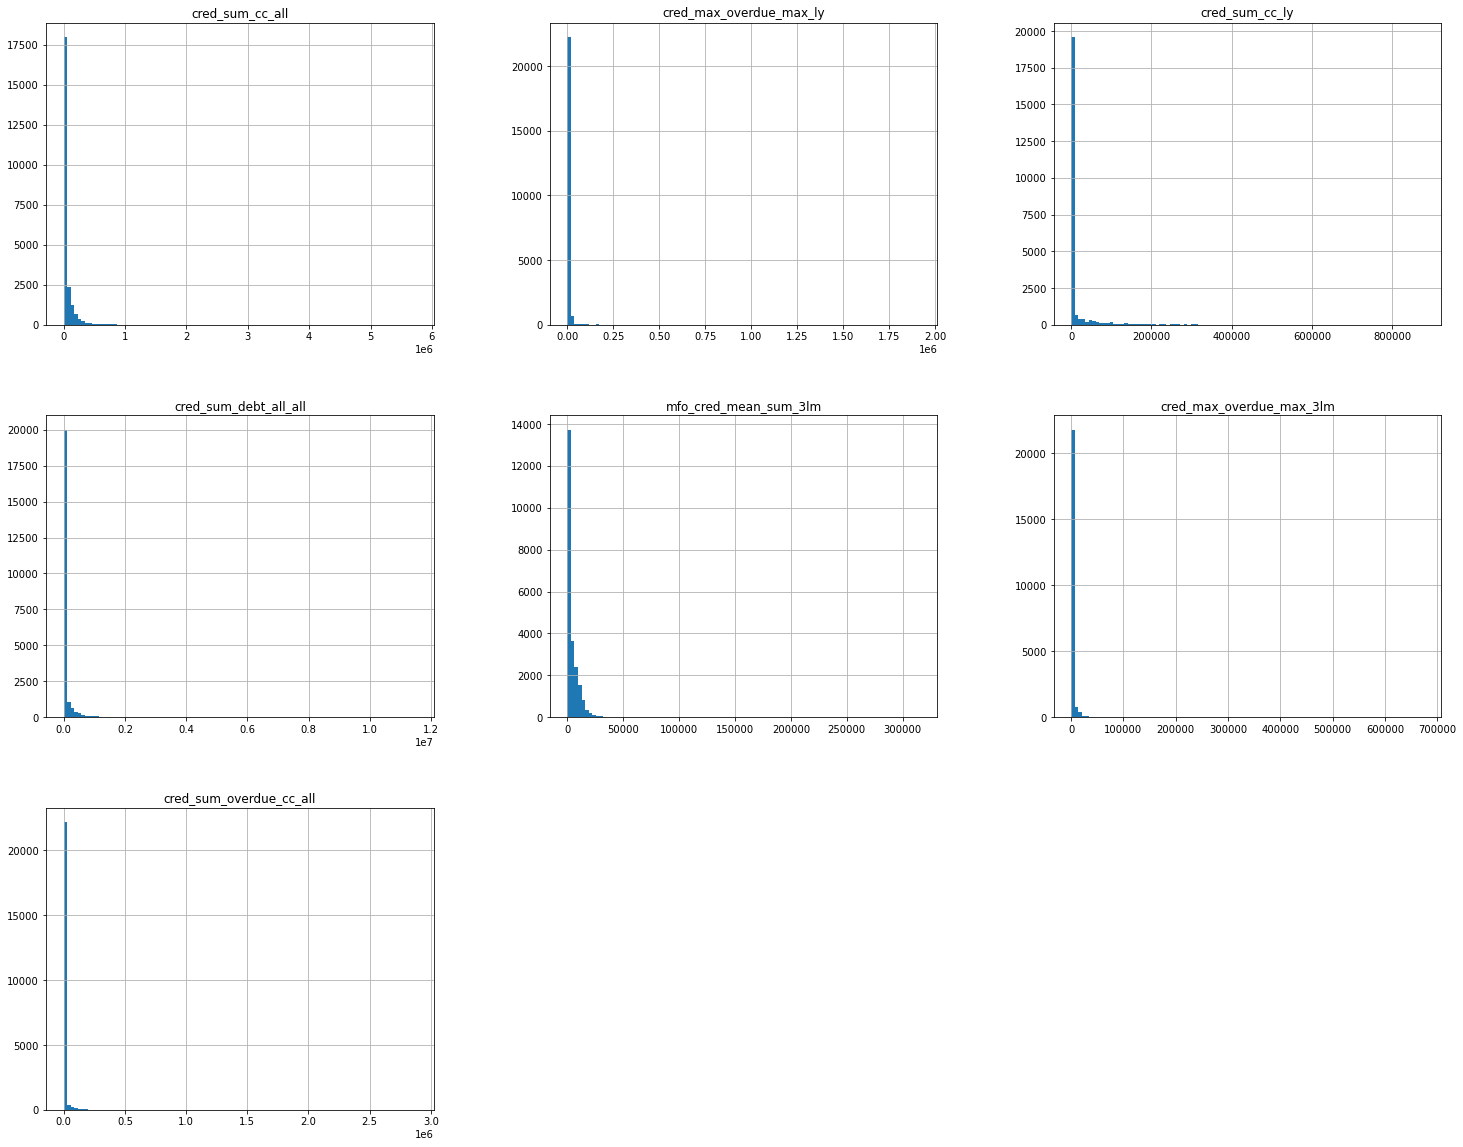

In [6]:
data[real_features].hist(figsize=(25,20),bins=100)
plt.plot()
plt.savefig('graph1.png')

## Графики распределения дискретных признаков

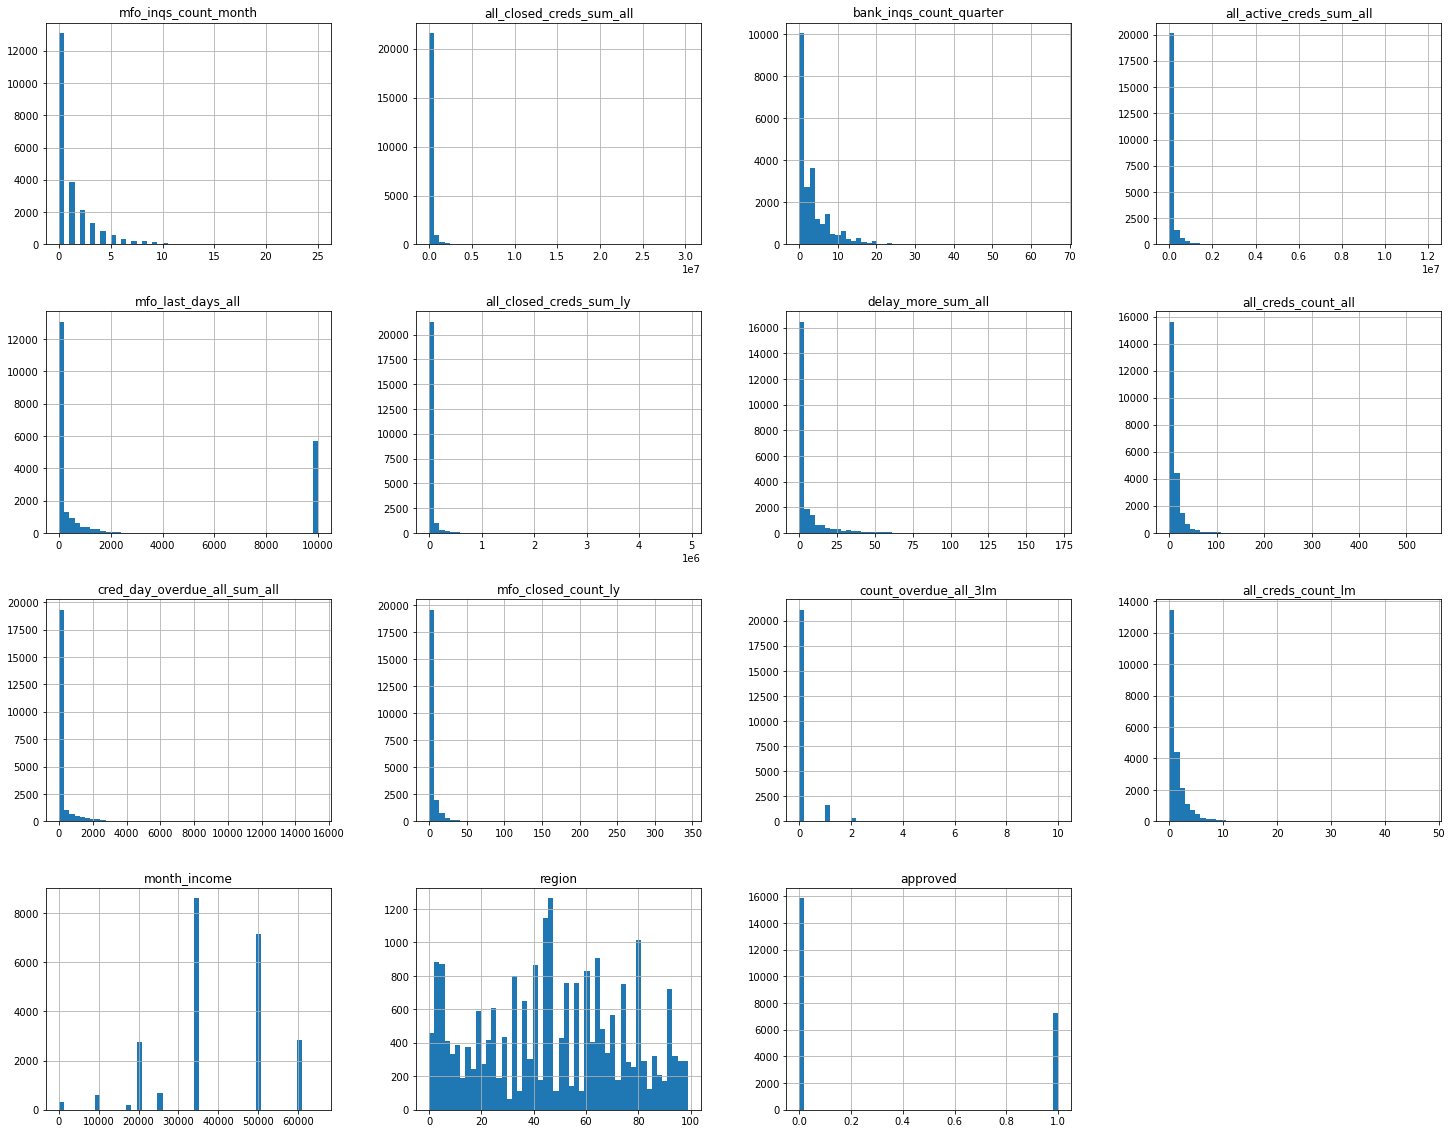

In [7]:
data[discrete_features].hist(figsize=(25,20),bins=50)
plt.plot()
plt.savefig('graph2.png')

In [8]:
data.bad=data.bad.fillna(-1) #заменяе nan значения признака bad для упрощения работы

С помощью бутстрэпа найдем сначала доверительные интервалы для медианных значений признаков каждой из выборок, а затем доверительные интервалы для для разности медиан двух выборок.

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)) )
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
def conf_int_95(col,n=100):
    values1 = data[data.bad!=(-1)][col].values
    values2 = data[col].values

    np.random.seed(0)

    values1_median_scores = list(map(np.median, get_bootstrap_samples(values1, n)))
    values2_median_scores = list(map(np.median, get_bootstrap_samples(values2, n)))
    
    min1,max1=stat_intervals(values1_median_scores, 0.05)[0],stat_intervals(values1_median_scores, 0.05)[1]
    
    min2,max2=stat_intervals(values2_median_scores, 0.05)[0],stat_intervals(values2_median_scores, 0.05)[1]
    

    #print("95% доверительный интервал "+str(col)+" для выданных кредитов(bad!=nan):",  stat_intervals(values1_median_scores, 0.05))
    #print("95% доверительный интервал "+str(col)+" для всей выборки:",  stat_intervals(values2_median_scores, 0.05))
    #print()
    
    delta_median_scores = list(map(lambda x: x[1] - x[0], zip(values1_median_scores, values2_median_scores)))
    
    delta_min,delta_max=stat_intervals(delta_median_scores, 0.05)[0],stat_intervals(delta_median_scores, 0.05)[1]
    
    #print("95% доверительный интервал для разности медиан",  stat_intervals(delta_median_scores, 0.05))
    return(min1,max1,min2,max2,delta_min,delta_max)

In [10]:
bad_nan_min=[]
bad_nan_max=[]

all_min=[]
all_max=[]

delta_min=[]
delta_max=[]


for feature in real_features:
    
    min1,max1,min2,max2,delt_min,delt_max=conf_int_95(feature,n=1000)
    
    bad_nan_min.append(min1)
    bad_nan_max.append(max1)
    
    all_min.append(min2)
    all_max.append(max2)
    
    delta_min.append(delt_min)
    delta_max.append(delt_max)
    
for feature in discrete_features:
    min1,max1,min2,max2,delt_min,delt_max=conf_int_95(feature,n=1000)
    
    bad_nan_min.append(min1)
    bad_nan_max.append(max1)
    
    all_min.append(min2)
    all_max.append(max2)
    
    delta_min.append(delt_min)
    delta_max.append(delt_max)
    

In [11]:
#создадим небольшой датафрейм для удобства прдеставления границ доверительных интервалов
feats=real_features+discrete_features
conf_intervals=pd.DataFrame(feats)

conf_intervals['bad_nan_min']=bad_nan_min
conf_intervals['bad_nan_max']=bad_nan_max

conf_intervals['all_min']=all_min
conf_intervals['all_max']=all_max

conf_intervals['delta_min']=delta_min
conf_intervals['delta_max']=delta_max

In [12]:
conf_intervals

,0,bad_nan_min,bad_nan_max,all_min,all_max,delta_min,delta_max
0,cred_sum_cc_all,30000.000000,32772.27900,5000.000,5000.000,-27772.279000,-25000.000000
1,cred_max_overdue_max_ly,0.000000,0.00000,0.000,0.000,0.000000,0.000000
2,cred_sum_cc_ly,0.000000,0.00000,0.000,0.000,0.000000,0.000000
3,cred_sum_debt_all_all,42078.807000,46700.00000,4500.000,5000.000,-41830.920875,-37168.423375
4,mfo_cred_mean_sum_3lm,6333.333333,6631.82807,724.375,1483.000,-5783.660714,-4952.753571
5,cred_max_overdue_max_3lm,0.000000,0.00000,0.000,0.000,0.000000,0.000000
6,cred_sum_overdue_cc_all,0.000000,0.00000,0.000,0.000,0.000000,0.000000
7,mfo_inqs_count_month,1.000000,1.00000,0.000,0.000,-1.000000,-1.000000
8,all_closed_creds_sum_all,87998.425000,97019.00000,29700.000,32000.000,-66297.837500,-57334.000000
9,bank_inqs_count_quarter,5.000000,5.00000,2.000,2.000,-3.000000,-3.000000


In [13]:
conf_intervals.to_csv('tabl_conf.csv',sep=';',encoding='utf-8', index=False)

In [14]:
#выведем признаки, доверительные интервалы которых для медианных значений не пересекаются для двух выборок
diff_feats=[]
for i in range(len(conf_intervals)):
    if (conf_intervals.iloc[i].delta_min>0) or (conf_intervals.iloc[i].delta_max<0):
        diff_feats.append(conf_intervals.iloc[i][0])
        print(conf_intervals.iloc[i][0])

cred_sum_cc_all
cred_sum_debt_all_all
mfo_cred_mean_sum_3lm
mfo_inqs_count_month
all_closed_creds_sum_all
bank_inqs_count_quarter
all_active_creds_sum_all
mfo_last_days_all
all_closed_creds_sum_ly
all_creds_count_all
mfo_closed_count_ly
all_creds_count_lm
month_income
approved


# Признаки отличающиеся на выборке выданных кредитов от всей выборки

#### cred_sum_cc_all- сумма кредитов по кредитным картам
Для случаев одобренных кредитов медианное значение заметно выше, чем по всей выборке. У людей с суммой кредитов выше явно большее количество одобренных кредитов, также можно предположить,что они берут кредиты, которые в состоянии оплатить, оценивая объективно свои финансовые способности

#### cred_sum_debt_all_all- Сумма задолженности по всем кредитам
По логике,если клиенту чаще одобряют кредиты, то выше вероятность появления задолженностей, возможно что им продолжают одобрять кредиты,так как время просрочки у них малое, либо они рано или поздно платят за кредит к тому же с процентами за просрочку, что выгодно для кредитора.


#### mfo_cred_mean_sum_3lm-Средняя сумма МФО кредитов, выданных за последние 3 месяца
В данном случае у одобренных кредитов это принак выше. Можно предположить, что если клиенту было одобрено много кредитов в последнее время, то у него хорошая кредитная история, так как выряд либы ему одобрили эти кредиты, то есть можно положиться на клиента, на которого положились в прошлом ,либо же можно предположить, что есть уверенность по другим признакам, что клиент вернет кредит рано или поздно, и в случае просрочки еще и заплатит процент.


#### mfo_inqs_count_month- количество запросов на кредиты в другие в МФО за месяц
Для одобренных кредитов медианное значение выше, могу предположить ,что данный признак надо рассматривать в купе с признаком возвращенных кредитов за последнее время, тогда человек обратившийся в последний месяц за кредитом и вернувший его выглдяит надежным. 

#### all_closed_creds_sum_all-Сумма закрытых кредитов за все время
Для выборки одобренных кредитов данный признак значительно выше, это легко объяснимо, если кредитор видит, чт клиент возвращает долги, то такой клиент выглядит надежным, и можно не беспокоиться о потере средств.


#### bank_inqs_count_quarter- количество запросов на кредиты в банки
Для одобренных кредитов данное значение выше, можно предположить, что если клиент обращается в банк, то у него  есть шанс на получение кредита, что невозможно без хорошей кредитной истории, а раз у него хорошая история, то такой клиент надежен. То есть если с клиентом работают банки, то следовательно с ним также можно работать.

#### all_active_creds_sum_all-денежная сумма всех активных кредитов
у одобренных кредитов данное значение больше, можно предположить, что данный признак логичнее рассматривать в отношении к зарплате, то есть оценивая финансовые возможности клиента.


#### mfo_last_days_all- Количество дней с последнего займа в МФО
Для одобренных кредитов данное значение ниже. Можно предположить ,что люди чаще обращающиеся за кредитами, лучше знакомы с данной ситуацией и могут оценить свое финансовое положение и грамотно вернуть занятые средства.


#### all_closed_creds_sum_ly-Сумма закрытых кредитов за последний год
также как и в случае с  суммами возвращенными за все время, человек возвращающий ердеиты выглядит надежным для кредитора и выгодно оформить ему кредит

#### mfo_closed_count_ly- Количество закрытых МФО кредитов, взятых за последний год
Для одобренных кредитов данный признак выше, что выглядит логичным. Клиенты закрыващие кредиты выглядят надежными и велика вероятность, что и вновь они вернут кредит



#### all_creds_count_all-Общее количество кредитов
У одобренных кредитов данное значение выше, можно предположить, что данный признак важен вкупе с другими признакми, так как например для клиента с малой зарплатой и с большим количеством кредитов меньше вероятность, что он вернет кредит, также важна сама сумма всех кредитов.

#### month_income-месячный доход
для одобренных кредитов данный признак выше, что абсолютно логично, так как человек имеющий бОльшие финансовые возможности выглдяит более надежным клиентом для кредитора, что дает гарантию на возврат кредита.

#### all_creds_count_lm-Количество кредитов, взятых за последний месяц
Для одобренных кредитов данное значение выше, данный признак логичнее рассматривать вкупе с признакками зарплаты, суммы кредитов.

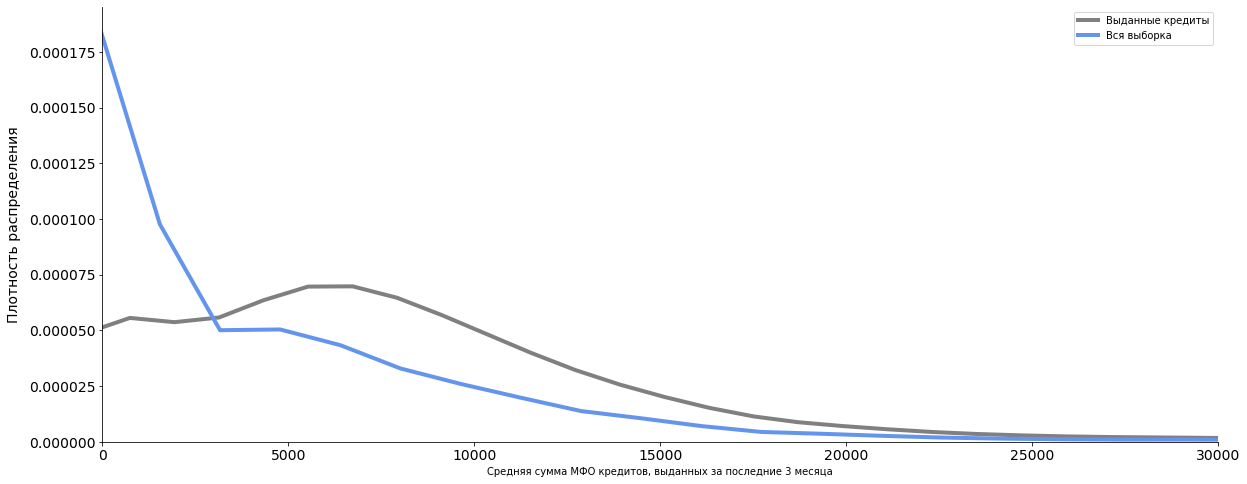

<Figure size 432x288 with 0 Axes>

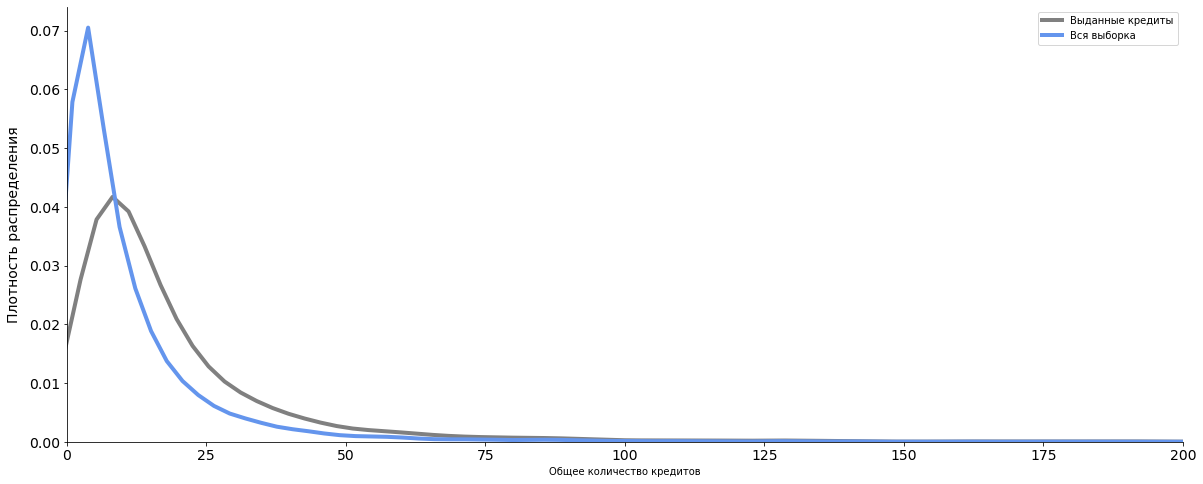

<Figure size 432x288 with 0 Axes>

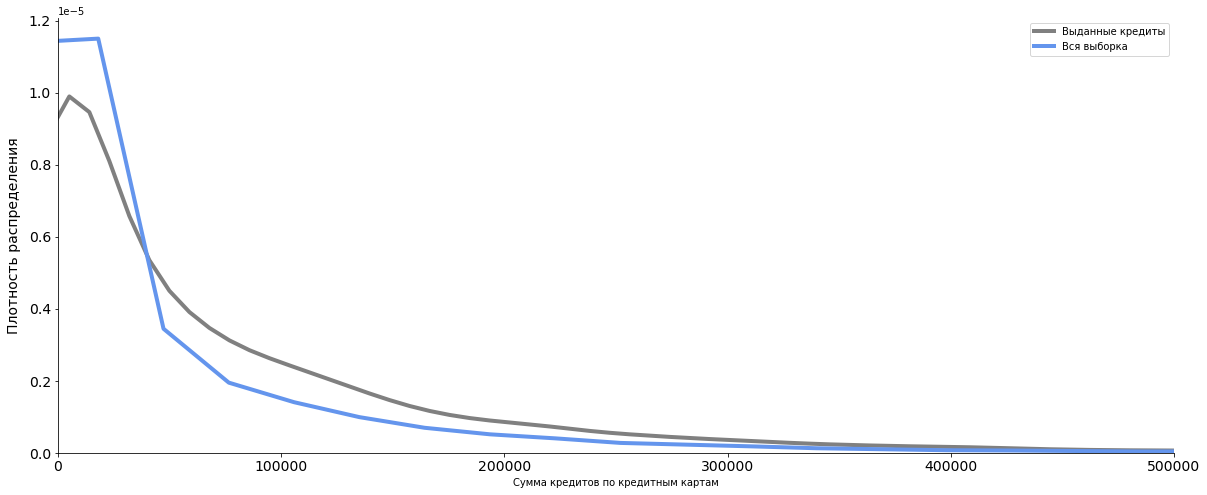

<Figure size 432x288 with 0 Axes>

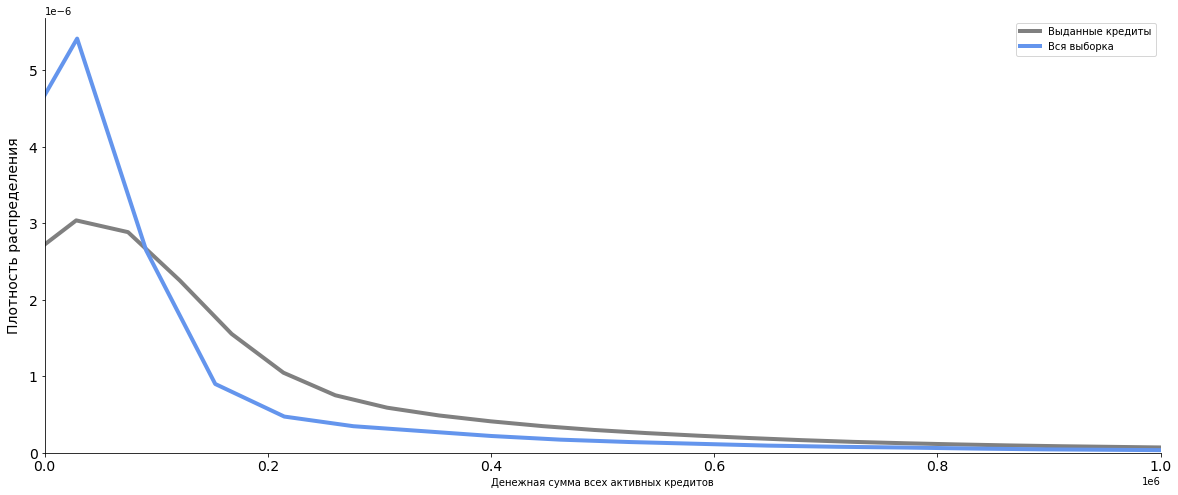

<Figure size 432x288 with 0 Axes>

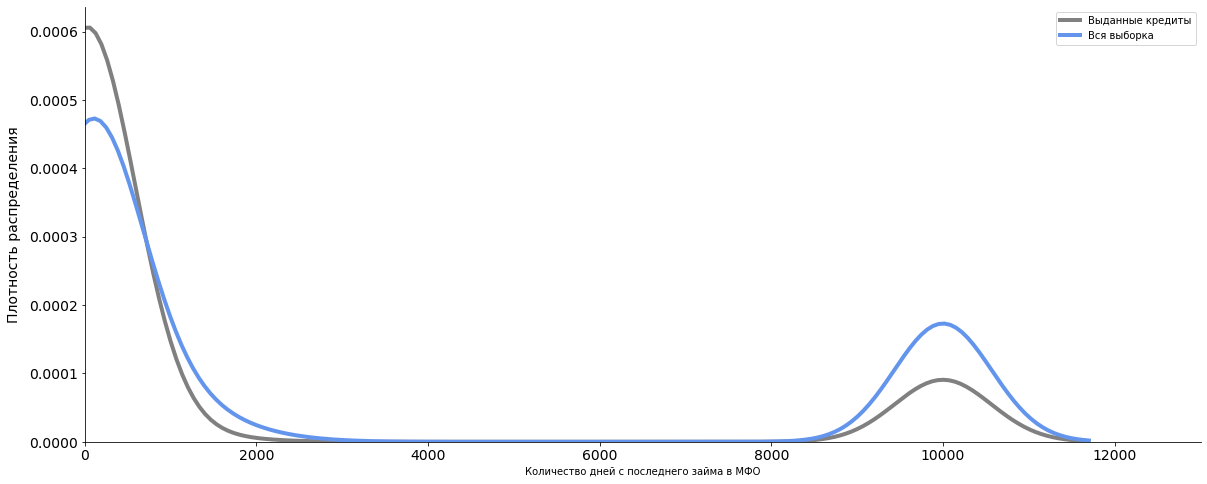

<Figure size 432x288 with 0 Axes>

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['mfo_cred_mean_sum_3lm'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['mfo_cred_mean_sum_3lm'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Средняя сумма МФО кредитов, выданных за последние 3 месяца')
plt.xlim(0,30000)
plt.legend()
plt.show()
plt.savefig('graph3.png')



plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['all_creds_count_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['all_creds_count_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Общее количество кредитов')
plt.xlim(0,200)
plt.legend()
plt.show()
plt.savefig('graph4.png')



plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['cred_sum_cc_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['cred_sum_cc_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Сумма кредитов по кредитным картам')
plt.xlim(0,500000)
plt.legend()
plt.show()
plt.savefig('graph5.png')



plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['all_active_creds_sum_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['all_active_creds_sum_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Денежная сумма всех активных кредитов')
plt.xlim(0,1000000)
plt.legend()
plt.show()
plt.savefig('graph6.png')




plt.figure(figsize=(20, 8))

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.ylabel('Плотность распределения', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(data[data.bad!=(-1)]['mfo_last_days_all'], hist=False, color='grey', axlabel=False, kde_kws={"linewidth": 4},label='Выданные кредиты')
sns.distplot(data['mfo_last_days_all'], hist=False, color='cornflowerblue', axlabel=False, kde_kws={"linewidth": 4},label='Вся выборка')
plt.xlabel('Количество дней с последнего займа в МФО')
plt.xlim(0,13000)
plt.legend()
plt.show()
plt.savefig('graph7.png')

# Признаки, чьи средние значения совпадают на обеих выборках

#### cred_max_overdue_max_ly-максимальная просрочка за год
Разница между медианными двух выборок не наблюдается.(Судя по значениям в этом признаке находится макс. сумма просроченного кредита, что неочевидно по названию). 
Исходя из этогоможно сказать, что сумма просрочки на год не влияет на одобрение кредита, тем не менее данный признак может быть разным для выборок,если рассматривать его вместе м каким-либо другим признаком вместе(сгенеррировать новые признаки).

#### cred_sum_cc_ly-Сумма лимитов кредитных карт, оформленных за последний год
Медианное значение для двух выборок равно нулю. Лимит кредитных карт может не отражать факт того, что клиент вернет кредит. Кредитная карта может иметь большой лимит, но клиент им никогда и не воспользуется, либо воспользуется, но на сумму гораздо меньшую лимита. Поэтому отсутсвие различий в двух выборках для этого признака вполне логично.

#### cred_max_overdue_max_3lm-Максимальная сумма просроченной задолженности, по кредитам взятым за последние 3 месяца
Медианное значение для двух выборок не отличается. Судя по графику, большие суммы задолженностей-это большая редкость, поэтомудля двух выборок нет различийв медианных значениях, можно предположить, что клиенты очень редко допускают большие просрочки по кредитам.


#### cred_sum_overdue_cc_all-Сумма просрочек по кредитным картам
Также как и для макс. суммы просрочек большинство клиентов не допускают больших просрочек по кредитным картам. Те клиенты, у которых такие все же имеются, можно рассматривать как выбросы. поэтому на медианных значениях это не отражается.



#### all_closed_creds_sum_ly-количество закрытых кредитов за год
Разницы между медианными значениями не наблюдается. Действительно, при выдаче нового кредита куда более важно знать примерно понимание финансового положения клиента, поэтому количество кредитов за последний период более показательно, так как у клиента могут быть разные периоды финансового положения на протяжении всей жизни.


#### cred_day_overdue_all_sum_all- Суммарное количество дней просрочки текущих активных кредитов
Медианные значения не различаются. Так как скорее всего большое колтчество лней просрочки имеется у самого минимального количества клиентов, что также может расцениваться, как выбросы. Возможно, что это просрочка по одному кредиту на малую сумму, но она составляет большое количество дней, это не дает стопроцентной гарантии, что взяв новый кредит он его не вернет.



#### count_overdue_all_3lm- Количество кредитов на просрочке, взятых за последние 3 месяца
Судя по графику, львиная доля клиентов не имеет просрочек вообще за последние три месяца и лишь малая часть имеет их более одного, то есть это можно рассматривать как выбросы.


#### region-регион
Нет различий, следовательно можно сделать вывод, что одбрение кредита не зависит от региона, где живет клиент.

#### delay_more_sum_all-Количество просрочек более чем на 90 дней по всем кредитам
Для всей выборки по оценке медианное значение равно 0, для выборки клиентов, которым одобрили кредит это значение составляет 1. И это не выглядит очевидным, возможно, что этот признак вкупе с какими-то другими признаками дает более логичное объяснение, например с количеством взятых кредитов за последний год или с суммой активных кредитов. Например, если у человека просрочка на 90 дней на малую сумму, при этом клиент всегда возарвщал предыдущие кредиты, и он берет еще один кредит также на малую сумму, то риск может быть на самом деле меньше, чем кажется на первый взгляд на наличие просрочки.

feature_13
feature_4
feature_8
feature_16
feature_9

# Обучение классификатора

In [16]:
# попытка создать новые признаки не увенчалась успехом
def data_feats(data):
 #   data['feature_1']=data['all_closed_creds_sum_all']/data['all_active_creds_sum_all']
    #data['feature_2']=data['cred_sum_cc_all']/data['cred_sum_debt_all_all']
  #  data['feature_3']=data['all_active_creds_sum_all']/data['all_creds_count_all']
   # data['feature_4']=data['all_closed_creds_sum_ly']/data['all_creds_count_all']
  #  data['feature_5']=data['cred_max_overdue_max_ly']/data['month_income']
  #  data['feature_6']=data['cred_sum_overdue_cc_all']/data['month_income']
  #  data['feature_7']=data['cred_max_overdue_max_ly']/data['month_income']
   # data['feature_8']=data['all_closed_creds_sum_ly']/data['mfo_closed_count_ly']
    #data['feature_9']=data['all_creds_count_lm']/data['mfo_inqs_count_month']
    #data['feature_10']=data['count_overdue_all_3lm']/3
    #data['feature_11']=data['all_creds_count_lm']/30
    #data['feature_12']=data['mfo_closed_count_ly']/12
    #data['feature_13']=data['mfo_inqs_count_month']/30
    #data['feature_14']=data['count_overdue_all_3lm']/data['all_creds_count_lm']
    #data['feature_15']=data['cred_max_overdue_max_3lm']/data['cred_max_overdue_max_ly']
    #data['feature_16']=data['all_active_creds_sum_all']/data['all_closed_creds_sum_all']
    #data['feature_17']=data['cred_max_overdue_max_3lm']/data['month_income']
    
    return data

In [17]:
import catboost as ctb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,train_test_split,TimeSeriesSplit

In [18]:
data=data_feats(data)
data=data.fillna(-999)

data.replace([np.inf, -np.inf], np.nan,inplace=True)

data_approved=data[data.approved==1]
data_approved=data_approved.sort_values('order_id')
#data_approved=data_approved.drop(['order_id'],axis=1)

target_approved=data_approved['bad'].astype('int32')


data_approved=data_approved.drop(['bad','approved'],axis=1)

data_approved=data_approved.fillna(-999)

<AxesSubplot:>

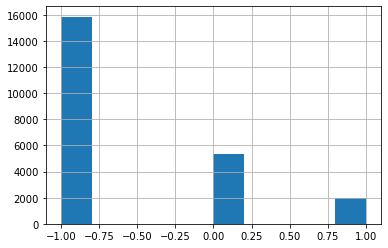

In [19]:
data['bad'].hist()

In [20]:
%%time
ctb_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    }

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_cv=GridSearchCV(ctb_clf,param_grid,cv=tscv,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_cv.fit(data_approved,target_approved)
print(cat_grid_cv.best_params_)

best_clf_1=cat_grid_cv.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..................................., score=0.569 total time=   4.1s
[CV 2/3] END ..................................., score=0.580 total time=   4.1s
[CV 3/3] END ..................................., score=0.577 total time=   4.7s
{}
Wall time: 18.7 s


In [21]:
#data_approved=data_approved.drop(['order_id'],axis=1)

In [22]:
feature_importances3=best_clf_1.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(data_approved),
                                     'feature_importances':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances',ascending=False)
feature_importances_df3

,features,feature_importances
0,order_id,8.175516
22,region,7.883965
3,all_closed_creds_sum_all,6.727619
10,all_closed_creds_sum_ly,6.308764
11,mfo_cred_mean_sum_3lm,5.751153
7,mfo_last_days_all,5.281313
6,all_active_creds_sum_all,5.268556
1,cred_sum_cc_all,5.149429
4,bank_inqs_count_quarter,5.047002
9,cred_sum_debt_all_all,5.040656


In [23]:
y_pred=best_clf_1.predict_proba(data_approved)[:,1]

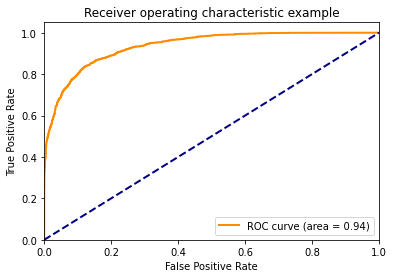

In [24]:

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(target_approved, y_pred)
roc_auc= auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
# загружаем и обрабатываем тестовые данные
data_test=pd.read_csv('test.csv')
data_test=data_feats(data_test)

data_test['bad']=data_test['bad'].fillna(-1)
data_test_approved=data_test[data_test.bad!=(-1)]
target_test_approved=data_test_approved['bad'].astype('int32')

data_test_approved=data_test_approved.drop(['bad'],axis=1)
data_test_approved=data_test_approved[data_approved.columns]

data_test_approved.replace([np.inf, -np.inf], np.nan,inplace=True)
data_test_approved=data_test_approved.fillna(-999)

In [26]:
import sklearn
import sklearn.neighbors
from sklearn.preprocessing import StandardScaler

In [27]:
best_clf_1.fit(data_approved,target_approved)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_1.predict_proba(data_test_approved)[:,1])

0.66084199660842

стандартные настройки выбивают большмй скор

## Теперь надо разметить невыданные кредиты
Попробуем с помощью KNN

In [28]:
scaler=StandardScaler()
scaler.fit(data_approved)

data_not_approved=data[data.bad==(-1)]
target_not_approved=data_not_approved['bad']

data_not_approved=data_not_approved.fillna(-999)


data_not_approved=data_not_approved[data_approved.columns]


scaled_not_approved=scaler.transform(data_not_approved)
scaled_data_train_approved=scaler.transform(data_approved)

In [29]:
knn=sklearn.neighbors.KNeighborsClassifier()
knn.fit(scaled_data_train_approved,target_approved)

KNeighborsClassifier()

<AxesSubplot:>

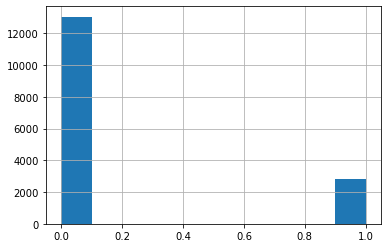

In [30]:
target_not_approved=knn.predict(scaled_not_approved)
pd.Series(list(target_not_approved)).hist(bins=10)

In [31]:
data_not_approved['bad']=target_not_approved
data_approved['bad']=target_approved

In [32]:
data_approved.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad
8,5499365,50000.0,2,58500,14,0.00,38000,23,50000.0,38000.00,...,0,0.0,5,0.0,0,2,1,35000,4,0
9,5499397,44000.0,1,367842,3,24000.00,74695,8,0.0,75295.00,...,0,0.0,11,0.0,0,3,2,35000,61,1
10,5499407,0.0,1,44500,0,0.00,5000,29,0.0,5000.00,...,0,0.0,7,0.0,0,1,4,50000,32,0
12,5499448,81550.0,11,231604,5,0.00,272086,16,0.0,217493.70,...,0,0.0,4,0.0,0,4,5,35000,1,1
17,5499715,45001.0,0,107584,0,5975.24,267484,9999,1.0,244351.87,...,0,0.0,0,0.0,0,0,5,35000,78,0


In [33]:
full_data=pd.concat([data_approved,data_not_approved])
full_data_target=full_data['bad']

full_data=full_data.drop(['bad'],axis=1)
#full_data=full_data.sort_values(by='order_id')

In [34]:
best_clf_2.fit(full_data,full_data_target)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_2.predict_proba(data_test_approved)[:,1])

NameError: name 'best_clf_2' is not defined

In [35]:
ctb_clf_2=ctb.CatBoostClassifier(verbose=0)
ctb_clf_2.fit(full_data,full_data_target)
sklearn.metrics.roc_auc_score(target_test_approved, ctb_clf_2.predict_proba(data_test_approved)[:,1])

0.6100420261004202

## Попробуем разметить через catboost

In [36]:
data_not_approved=data[data.bad==(-1)]
data_not_approved=data_not_approved.fillna(-999)
data_not_approved=data_not_approved[data_approved.columns]
y_predicted_prob=best_clf_1.predict_proba(data_not_approved)[:,1]

<AxesSubplot:>

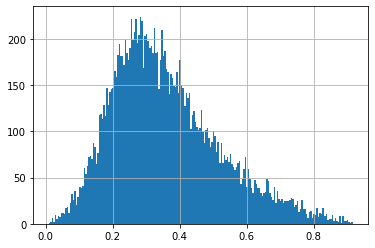

In [37]:
pd.Series(y_predicted_prob).hist(bins=200)

<AxesSubplot:>

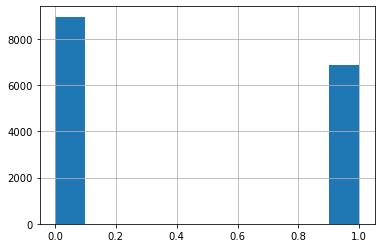

In [38]:
target_not_approved=np.where(y_predicted_prob>np.mean(y_predicted_prob),1,0) #threshold для отнесения к классу невозвращенных
#кредитов выбирается медианное значение вероятности возврата


pd.Series(target_not_approved).hist()

In [39]:
data_not_approved['bad']=target_not_approved
data_approved['bad']=target_approved

full_data=pd.concat([data_approved,data_not_approved])

full_target=full_data['bad']
full_data=full_data.drop(['bad'],axis=1)

#full_data=full_data.sort_values(by='order_id')

In [40]:
#full_data=full_data.drop(['order_id'],axis=1)

In [41]:
full_data.head()

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,all_creds_count_all,cred_day_overdue_all_sum_all,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region
8,5499365,50000.0,2,58500,14,0.00,38000,23,50000.0,38000.00,...,9,0,0.0,5,0.0,0,2,1,35000,4
9,5499397,44000.0,1,367842,3,24000.00,74695,8,0.0,75295.00,...,32,0,0.0,11,0.0,0,3,2,35000,61
10,5499407,0.0,1,44500,0,0.00,5000,29,0.0,5000.00,...,8,0,0.0,7,0.0,0,1,4,50000,32
12,5499448,81550.0,11,231604,5,0.00,272086,16,0.0,217493.70,...,23,0,0.0,4,0.0,0,4,5,35000,1
17,5499715,45001.0,0,107584,0,5975.24,267484,9999,1.0,244351.87,...,8,0,0.0,0,0.0,0,0,5,35000,78


In [42]:
%%time
ctb_clf=ctb.CatBoostClassifier(verbose=0)
param_grid = {
    'iterations' : [2000],
    "learning_rate": [0.004],
    'depth':[4]}

tscv=TimeSeriesSplit(n_splits=3)
cat_grid_cv=GridSearchCV(ctb_clf,param_grid,cv=tscv,n_jobs=1,verbose=3,scoring='roc_auc')


cat_grid_cv.fit(full_data,full_target)
print(cat_grid_cv.best_params_)

best_clf_3=cat_grid_cv.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END depth=4, iterations=2000, learning_rate=0.004;, score=0.854 total time=   7.2s
[CV 2/3] END depth=4, iterations=2000, learning_rate=0.004;, score=0.941 total time=  11.3s
[CV 3/3] END depth=4, iterations=2000, learning_rate=0.004;, score=0.932 total time=  13.2s
{'depth': 4, 'iterations': 2000, 'learning_rate': 0.004}
Wall time: 45.8 s


In [43]:
feature_importances3=best_clf_3.feature_importances_
feature_importances_df3=pd.DataFrame({'features':list(full_data),
                                     'feature_importances':feature_importances3})
feature_importances_df3=feature_importances_df3.sort_values('feature_importances',ascending=False)
feature_importances_df3

,features,feature_importances
14,cred_day_overdue_all_sum_all,18.301734
3,all_closed_creds_sum_all,15.951970
20,work_code,12.156779
18,count_overdue_all_3lm,6.917431
5,cred_max_overdue_max_ly,6.239485
10,all_closed_creds_sum_ly,4.635603
0,order_id,4.471017
6,all_active_creds_sum_all,3.903154
7,mfo_last_days_all,3.850770
4,bank_inqs_count_quarter,3.434942


In [44]:
best_clf_3.fit(full_data,full_target)
sklearn.metrics.roc_auc_score(target_test_approved, best_clf_3.predict_proba(data_test_approved)[:,1])

0.6465383764653836

## Через Catboost с частичным привлечением учителя

сделаем следующее: предскажем с помощью первой модели вероятность отнесения к классу 1, и сохраним те объекты, в которых модель уверена больше всего, для этого мы с помощью 5 и 95 процентилей отбираем вероятности из массива вроятностей всех неодобренных кредитов

In [45]:
pd.options.mode.chained_assignment = None  # default='warn'

In [46]:
data_not_approved=data[data.bad==(-1)]
data_not_approved=data_not_approved.fillna(-999)
data_not_approved=data_not_approved[data_approved.columns]

In [47]:
#data_approved=data_approved.drop(['bad'],axis=1)

best_clf_1=ctb.CatBoostClassifier(verbose=0)
best_clf_1.fit(data_approved,target_approved)
#sklearn.metrics.roc_auc_score(target_approved, best_clf_1.predict_proba(data_approved)[:,1])

In [48]:
score=[]

In [49]:
for i in range(10):
    y_predicted_prob=best_clf_1.predict_proba(data_not_approved)[:,1]

    percent_5=np.percentile(y_predicted_prob, 1)
    percent_95=np.percentile(y_predicted_prob, 99)

    index_percent_5=[]
    index_percent_95=[]

    for i,prob in enumerate(y_predicted_prob):
        if prob<percent_5:
            index_percent_5.append(i)
        if prob>percent_95:
            index_percent_95.append(i)
        
        
    data_not_approved['prob']=y_predicted_prob
    data_not_approved['bad']=np.nan


    data_not_approved_1=data_not_approved[data_not_approved['prob']<percent_5]
    data_not_approved_2=data_not_approved[data_not_approved['prob']>percent_95]

    data_not_approved_1['bad']=0
    data_not_approved_1=data_not_approved_1.drop(['prob'],axis=1)

    data_not_approved_2['bad']=1
    data_not_approved_2=data_not_approved_2.drop(['prob'],axis=1)

    target_not_approved_conf=pd.concat([data_not_approved_1,data_not_approved_2])


    data_approved['bad']=target_approved

    full_data=pd.concat([data_approved,target_not_approved_conf])

    full_target=full_data['bad']
    full_data=full_data.drop(['bad'],axis=1)


    best_clf_1=ctb.CatBoostClassifier(verbose=0)
    best_clf_1.fit(full_data,full_target)
    
    data_not_approved.drop(list(target_not_approved_conf.index), inplace=True)
    
    #print(len(target_not_approved_conf))

    #print(sklearn.metrics.roc_auc_score(target_test_approved, best_clf_1.predict_proba(data_test_approved)[:,1]))
    
    score.append(sklearn.metrics.roc_auc_score(target_test_approved, best_clf_1.predict_proba(data_test_approved)[:,1]))

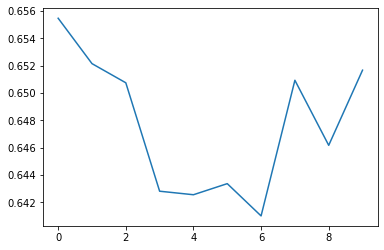

In [50]:
plt.plot(np.arange(0,10),score)